## <font color='cornflowerblue'> Packages

In [1]:
import ta
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

## <font color='cornflowerblue'> Classes and Functions

In [2]:
from dataclasses import dataclass

@dataclass
class Position:
    """ A cool representation of a position
    """
    ticker: str
    n_shares: int
    price: float
    sl: float
    tp: float
    deposit: float
    time: str

In [3]:
def rsi(data: pd.DataFrame, window: int, rsi_lower: int, rsi_upper: int) -> pd.DataFrame:
    df = data.copy()
    rsi_indicator = ta.momentum.RSIIndicator(df.Close, window=window)
    df['rsi'] = rsi_indicator.rsi()
    df['buy_signal'] = df['rsi'] < rsi_lower
    df['sell_signal'] = df['rsi'] > rsi_upper
    df = df.dropna()
    return df

In [4]:
def get_portfolio_value(cash: float, long_ops: list[Position], short_ops: list[Position], current_price: float, 
                        n_shares: int, COM: float, INITIAL_MARGIN: float) -> float:
    val = cash

    # Add long positions value
    val += len(long_ops) * current_price * n_shares * (1 - COM)

    # Add short positions equity (margin_account + margin_requirement - cost to cover)
    for pos in short_ops:
        # Margin requirement when position opened
        margin_requirement = pos.price * pos.n_shares * INITIAL_MARGIN
        # Unrealized PnL from short
        pnl = (pos.price - current_price) * pos.n_shares * (1 - COM)
        # Equity = margin deposit + unrealized PnL
        equity = margin_requirement + pnl  
        val += equity
        
    return val

In [5]:
def get_portfolio_value_2(cash: float, long_ops: list[Position], short_ops: list[Position], current_price: float, 
                        n_shares: int, COM: float, INITIAL_MARGIN: float) -> float:
    
    val = cash 

    # Longs
    val += len(long_ops) * current_price * n_shares * (1 - COM)

    # Shorts
    short_val = sum(
        pos.price * pos.n_shares * INITIAL_MARGIN + (pos.price - current_price) * pos.n_shares * (1 - COM) + pos.deposit
        for pos in short_ops
    )

    return val + short_val

## <font color='cornflowerblue'> Data

In [6]:
data = pd.read_csv('aapl_5m_train.csv').dropna()

In [7]:
data = rsi(data, window=15, rsi_lower=20, rsi_upper=80)
data.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume,rsi,buy_signal,sell_signal
14,14,1609774800,0,2021-01-04 15:40:00,131.111297,131.309997,131.029998,131.044998,1253385.0,35.472015,False,False
15,15,1609775100,0,2021-01-04 15:45:00,131.044006,131.044006,130.479995,130.749893,1730254.0,31.779676,False,False
16,16,1609775400,0,2021-01-04 15:50:00,130.750000,130.830001,130.449996,130.709793,1887654.0,31.305254,False,False
17,17,1609775700,0,2021-01-04 15:55:00,130.700103,131.250000,130.699996,131.000000,1608419.0,38.432075,False,False
18,18,1609776000,0,2021-01-04 16:00:00,131.134994,131.309997,130.160003,130.309997,2055970.0,30.398179,False,False


## <font color='cornflowerblue'> Parameters

In [8]:
COM: float = 0.125 / 100
BORROW_RATE: float = 0.25 / 100
INITIAL_MARGIN = 1.5
MAINTENANCE_MARGIN = 0.25

# Convert annualized borrow rate to 5-min bar rate
bars_per_year = 252 * 6.5 * 60 / 5  # 252 trading days, 6.5 hours per day, 5-min bars
bar_borrow_rate = BORROW_RATE / bars_per_year

# DOF
STOP_LOSS: float = 0.5
TAKE_PROFIT: float = 0.1
N_SHARES: int = 50

## <font color='cornflowerblue'> Backtest

In [9]:
capital: float = 1_000_000
margin_account: float = 0.0

portfolio_value = [capital]
active_long_positions: list[Position] = []
active_short_positions: list[Position] = []

for i, row in data.iterrows():
    # -- LONG -- #
    # Check active orders
    for position in active_long_positions.copy():
        # Stop loss or take profit check
        if row.Close > position.tp or row.Close < position.sl:
            # Add profits / losses to capital
            capital += row.Close * position.n_shares * (1 - COM)
            # Remove position from active position
            active_long_positions.remove(position)

    equity: float = 0.0
    required_equity: float = 0.0

    # -- SHORT -- #
    for position in active_short_positions.copy():
        # Apply borrow rate to active short positions
        cover_cost = row.Close * position.n_shares
        initial_account = position.price * position.n_shares * INITIAL_MARGIN
        borrow_cost = cover_cost * bar_borrow_rate

        capital -= borrow_cost
        equity += initial_account - cover_cost + position.deposit
        required_equity += MAINTENANCE_MARGIN * cover_cost
        #required_equity += MAINTENANCE_MARGIN * row.Close * position.n_shares

    for position in active_short_positions.copy():
        # Check Margin call
        if equity < required_equity:
            # Margin Call
            deposit = (required_equity - equity) * 2
            if capital > deposit:
                print(f'Margin Call at {row.Datetime} | Equity: {equity:.2f} | Required Equity: {required_equity:.2f} | Deposit: {deposit:.2f}')
                capital -= deposit
                equity += deposit
                position.deposit += deposit

            else:
                # We have to close the position
                print(f'Forced Close at {row.Datetime} | Equity: {equity:.2f} | Required Equity: {required_equity:.2f} | Deposit Needed: {deposit:.2f} | Capital: {capital:.2f} \n')
                pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
                capital += pnl + position.price * position.n_shares * INITIAL_MARGIN + position.deposit

                equity -= position.price * position.n_shares * INITIAL_MARGIN - row.Close * position.n_shares + position.deposit
                required_equity -= MAINTENANCE_MARGIN * row.Close * position.n_shares
                active_short_positions.remove(position)
                continue

        if row.Close < position.tp or row.Close > position.sl:
            # Add profits / losses to capital
            pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
            capital += pnl + position.price * position.n_shares * INITIAL_MARGIN + position.deposit

            equity -= position.price * position.n_shares * INITIAL_MARGIN - row.Close * position.n_shares + position.deposit
            required_equity -= MAINTENANCE_MARGIN * row.Close * position.n_shares
            active_short_positions.remove(position)
            continue

    # Check Long Signal
    if getattr(row, "buy_signal", False):
        cost = row.Close * N_SHARES * (1 + COM)

        # Do we have enough cash?
        if capital > cost:
            # Discount cash
            capital -= cost
            # Add position to portfolio
            pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                           sl=row.Close * (1 - STOP_LOSS), tp=row.Close*(1 + TAKE_PROFIT),
                           deposit=0, time=row.Datetime)
            active_long_positions.append(pos)

    # Check Short Signal
    if getattr(row, "sell_signal", False):
        margin_requirement = row.Close * N_SHARES * INITIAL_MARGIN
        commission = row.Close * N_SHARES * COM

        # Do we have enough cash?
        if capital > margin_requirement:
            # Discount cash
            capital -= margin_requirement + commission
            # Add position to portfolio
            pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                           sl=row.Close * (1 + STOP_LOSS), tp=row.Close*(1 - TAKE_PROFIT),
                           deposit=0, time=row.Datetime)
            active_short_positions.append(pos)

    # Calculate portfolio value
    portfolio_value.append(get_portfolio_value_2(capital, active_long_positions, active_short_positions, row.Close, N_SHARES, COM, INITIAL_MARGIN))
    continue
# At the end of the backtesting, we should close all active positions
capital += row.Close * len(active_long_positions) * N_SHARES * (1 - COM)

for position in active_short_positions:
    pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
    capital += pnl + position.price * N_SHARES * INITIAL_MARGIN + position.deposit
    equity -= position.price * position.n_shares * INITIAL_MARGIN - row.Close * position.n_shares + position.deposit
    required_equity -= MAINTENANCE_MARGIN * row.Close * position.n_shares

active_long_positions = []
active_short_positions = []

Margin Call at 2021-12-01 15:40:00 | Equity: 206603.58 | Required Equity: 208778.63 | Deposit: 4350.11
Margin Call at 2021-12-01 15:45:00 | Equity: 208182.23 | Required Equity: 209471.50 | Deposit: 2578.54
Margin Call at 2021-12-01 16:05:00 | Equity: 209522.74 | Required Equity: 209781.00 | Deposit: 516.54
Margin Call at 2021-12-01 16:10:00 | Equity: 208232.57 | Required Equity: 210232.68 | Deposit: 4000.22
Margin Call at 2021-12-07 14:40:00 | Equity: 210426.01 | Required Equity: 210684.38 | Deposit: 516.73
Margin Call at 2021-12-07 14:45:00 | Equity: 209705.24 | Required Equity: 210993.75 | Deposit: 2577.02
Margin Call at 2021-12-07 15:10:00 | Equity: 210787.35 | Required Equity: 211367.48 | Deposit: 1160.25
Margin Call at 2021-12-07 15:45:00 | Equity: 210211.14 | Required Equity: 211801.59 | Deposit: 3180.90
Margin Call at 2021-12-07 17:25:00 | Equity: 211611.55 | Required Equity: 212246.71 | Deposit: 1270.32
Forced Close at 2021-12-08 14:35:00 | Equity: 210320.24 | Required Equity: 

In [10]:
capital, equity, required_equity

(1155974.1044595176, 5.093170329928398e-11, 4.547473508864641e-13)

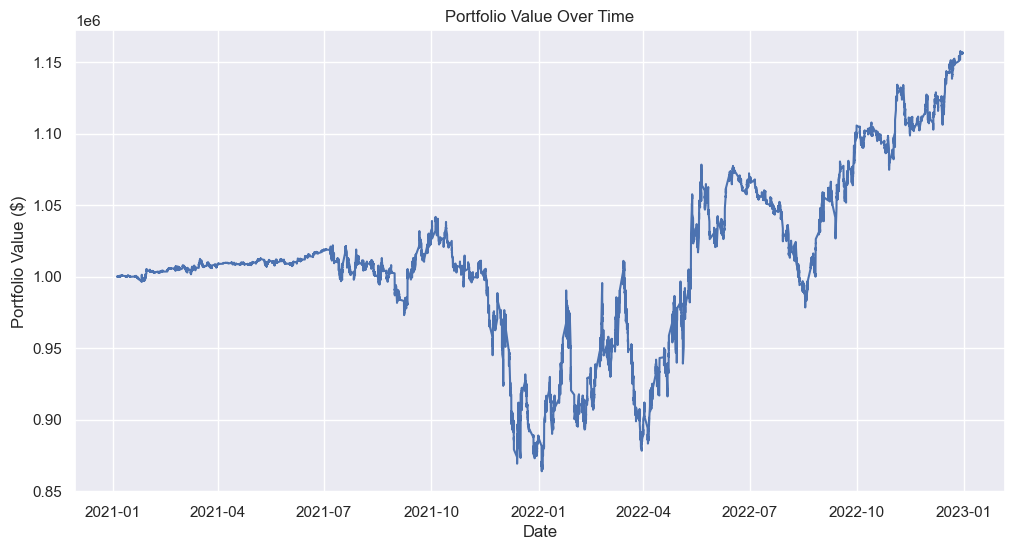

In [11]:
df = pd.DataFrame({'Portfolio Value': portfolio_value[1:]},
                  index=pd.to_datetime(data.Datetime))

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Portfolio Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.show()